In [1]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import json
from signatures.tensor_algebra import TensorAlgebra
from signatures.tensor_sequence import TensorSequence
from scipy.optimize import minimize

In [2]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: user 2min 55s, sys: 283 ms, total: 2min 55s
Wall time: 2min 56s


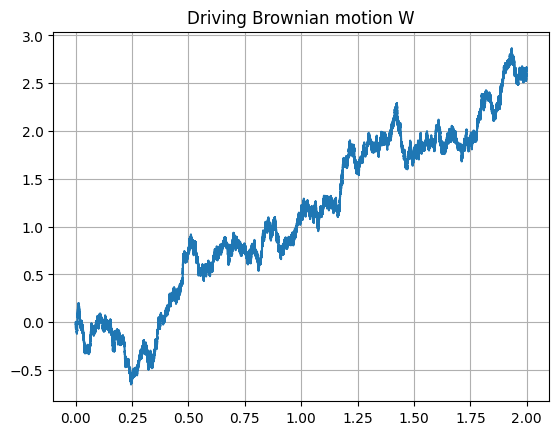

In [3]:
points_per_day = 7200 # 4 sec sampling frequency
T = 2

t_grid = np.linspace(0, T, points_per_day * T * 365 + 1)

rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

fig, ax = plt.subplots()

ax.plot(t_grid, W)
ax.set_title("Driving Brownian motion W")
ax.grid()

## Simple case: $\sigma_t = W_t$

In [5]:
vol_inst = W
X = np.concatenate([[0], np.cumsum(-0.5 * vol_inst[:-1]**2 * np.diff(t_grid) + vol_inst[:-1] * np.diff(W))])
S = np.exp(X)

Text(0.5, 1.0, 'Price trajectory daily')

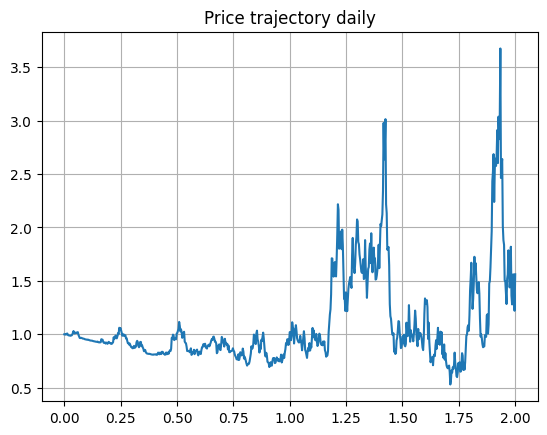

In [6]:
t_daily = t_grid[::points_per_day]
S_daily = S[::points_per_day]
X_daily = X[::points_per_day]
W_daily = W[::points_per_day]

fig, ax = plt.subplots()
ax.plot(t_daily, S_daily)
ax.grid()
ax.set_title("Price trajectory daily")

In [7]:
path = np.vstack([t_daily, W_daily]).T
N = 10
W_sig = ta.path_to_sequence(path=path, trunc=N)

In [8]:
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_221 = ta.from_dict({"221": 1}, trunc=N)

In [10]:
def sig_log_price_from_sig_vol(sig_vol):
    return sig_vol.tensor_prod_word("2") - 0.5 * (sig_vol.proj("2") + sig_vol.shuffle_pow(2)).tensor_prod_word("1")
    
sig_log_price = sig_log_price_from_sig_vol(_2)
ta.print(sig_log_price)

-0.5*1 + 1.0*22 + -1.0*221


Text(0.5, 1.0, 'Price trajectory daily')

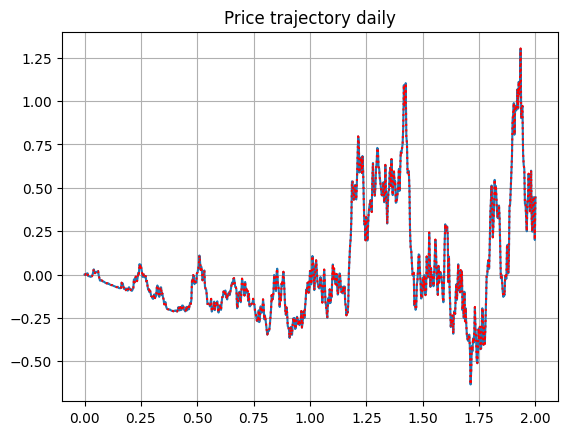

In [11]:
fig, ax = plt.subplots()

ax.plot(t_daily, X_daily)
ax.plot(t_daily, np.real(W_sig @ sig_log_price), "r:")
ax.grid()
ax.set_title("Price trajectory daily")

In [12]:
trunc = 3
n_params = 2**(trunc + 1) - 1
in_sample_idx = 366
lam = 1e-5

def loss_log_price(l):
    vol_coef = ta.from_array(array=l, trunc=trunc*2 + 1)
    sig_log_price = sig_log_price_from_sig_vol(vol_coef)
    return np.mean((X_daily - np.real(W_sig @ sig_log_price).squeeze())[:in_sample_idx]**2) + lam * np.sum(np.abs(l))

l0 = np.zeros(n_params)
res = minimize(fun=loss_log_price, x0=l0)

In [13]:
# TODO: add as method to TensorAlgebra

def plot_coefficients(ts, trunc: int, ax: plt.axis = None, **kwargs):    
    n_coefs = 2**(trunc + 1) - 1
    coefs = np.zeros(n_coefs)
    coefs[ts.indices] = ts.array.squeeze().real
    
    if ax is None:
        fig, ax = plt.subplots()    
    ax.plot(coefs, "o", **kwargs)
    ax.grid("on")
    ax.set_xticks(ticks=np.arange(n_coefs), labels=[ta.alphabet.index_to_word(i) for i in range(n_coefs)], rotation=-90)
    ax.plot()

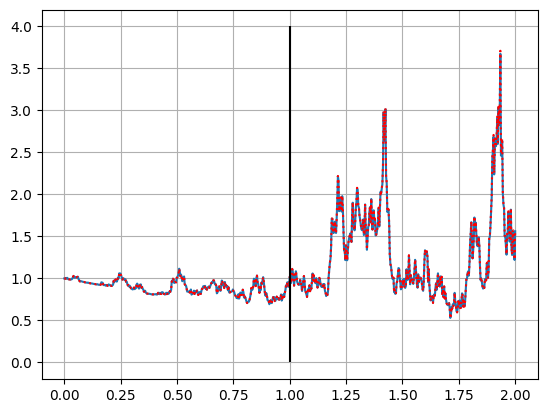

In [15]:
l_reg = ta.from_array(array=res.x, trunc=trunc*2 + 1)
sig_log_price_reg = sig_log_price_from_sig_vol(l_reg)

fig, ax = plt.subplots()
ax.plot(t_daily, S_daily)
ax.plot(t_daily, np.exp(np.real(W_sig @ sig_log_price_reg)), "r:")
ax.vlines(x=1, ymin=0, ymax=4, color="k")
ax.grid()

/tmp/ipykernel_145238/948511884.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefs, "o", **kwargs)


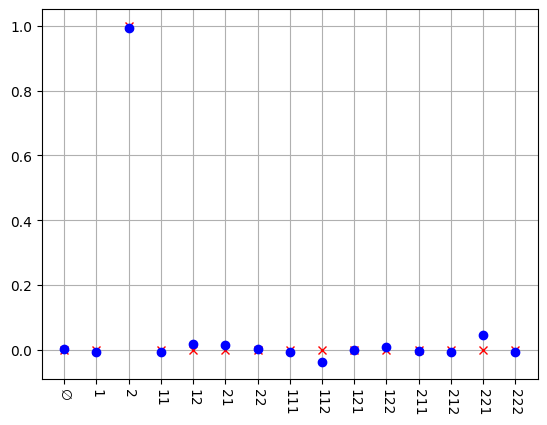

In [16]:
fig, ax = plt.subplots()

plot_coefficients(_2, trunc=3, ax=ax, color="r", marker="x")
plot_coefficients(ts=l_reg, trunc=3, ax=ax, color="b")

## OU case: $d\sigma_t = \kappa (\theta - \sigma_t) dt + \nu dW_t$

In [4]:
kappa = 100
theta = 0.2
nu = 0.5

vol_inst = np.zeros_like(W)
vol_inst[0] = theta
dt = np.diff(t_grid)
dW = np.diff(W)
for i in range(vol_inst.size - 1):
    vol_inst[i + 1] = vol_inst[i] + kappa * (theta - vol_inst[i]) * dt[i] + nu * dW[i]

X = np.concatenate([[0], np.cumsum(-0.5 * vol_inst[:-1]**2 * np.diff(t_grid) + vol_inst[:-1] * np.diff(W))])
S = np.exp(X)

Text(0.5, 1.0, 'Instantaneous volatility')

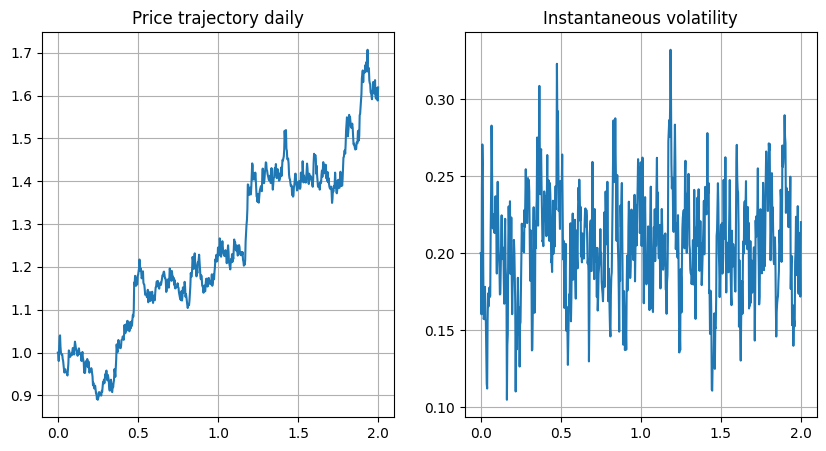

In [5]:
t_daily = t_grid[::points_per_day]
S_daily = S[::points_per_day]
X_daily = X[::points_per_day]
W_daily = W[::points_per_day]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t_daily, S_daily)
ax[0].grid()
ax[0].set_title("Price trajectory daily")

ax[1].plot(t_daily, vol_inst[::points_per_day])
ax[1].grid()
ax[1].set_title("Instantaneous volatility")

In [6]:
path = np.vstack([t_daily, W_daily]).T
N = 10
W_sig = ta.path_to_sequence(path=path, trunc=N)

In [7]:
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_221 = ta.from_dict({"221": 1}, trunc=N)

In [8]:
def sig_log_price_from_sig_vol(sig_vol):
    return sig_vol.tensor_prod_word("2") - 0.5 * (sig_vol.proj("2") + sig_vol.shuffle_pow(2)).tensor_prod_word("1")

In [13]:
trunc = 3
n_params = 2**(trunc + 1) - 1
in_sample_idx = 366
lam = 5e-5

def loss_log_price(l):
    vol_coef = ta.from_array(array=l, trunc=trunc*2 + 1)
    sig_log_price = sig_log_price_from_sig_vol(vol_coef)
    return np.mean((X_daily - np.real(W_sig @ sig_log_price).squeeze())[:in_sample_idx]**2) + lam * np.sum(np.abs(l))

l0 = np.zeros(n_params)
res = minimize(fun=loss_log_price, x0=l0)

In [14]:
# TODO: add as method to TensorAlgebra

def plot_coefficients(ts, trunc: int, ax: plt.axis = None, **kwargs):    
    n_coefs = 2**(trunc + 1) - 1
    coefs = np.zeros(n_coefs)
    coefs[ts.indices] = ts.array.squeeze().real
    
    if ax is None:
        fig, ax = plt.subplots()    
    ax.plot(coefs, "o", **kwargs)
    ax.grid("on")
    ax.set_xticks(ticks=np.arange(n_coefs), labels=[ta.alphabet.index_to_word(i) for i in range(n_coefs)], rotation=-90)
    ax.plot()

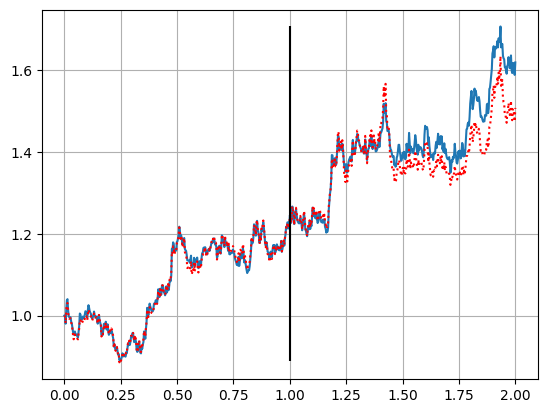

In [15]:
l_reg = ta.from_array(array=res.x, trunc=trunc*2 + 1)
sig_log_price_reg = sig_log_price_from_sig_vol(l_reg)

fig, ax = plt.subplots()
ax.plot(t_daily, S_daily)
ax.plot(t_daily, np.exp(np.real(W_sig @ sig_log_price_reg)), "r:")
ax.vlines(x=1, ymin=np.min(S_daily), ymax=np.max(S_daily), color="k")
ax.grid()

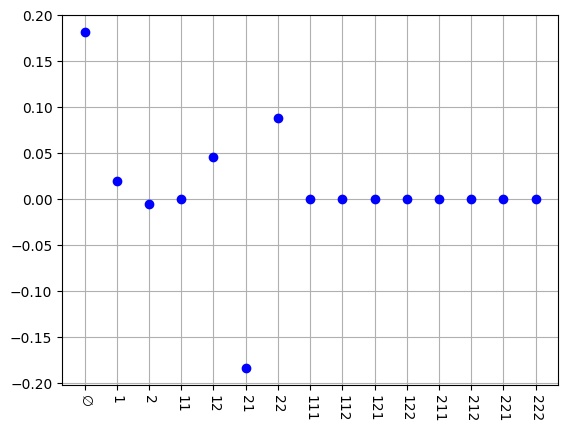

In [29]:
fig, ax = plt.subplots()

plot_coefficients(ts=l_reg, trunc=3, ax=ax, color="b")

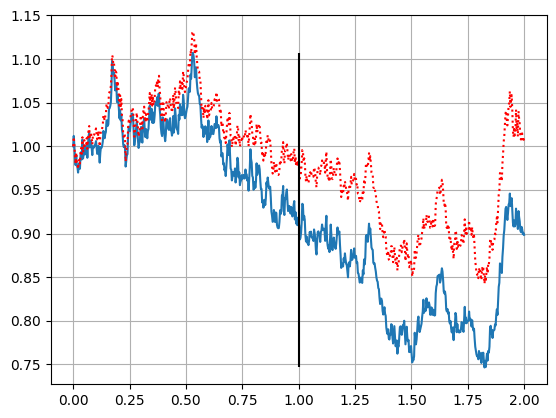

In [26]:
W_new = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

vol_inst = np.zeros_like(W_new)
vol_inst[0] = theta
dt = np.diff(t_grid)
dW = np.diff(W_new)
for i in range(vol_inst.size - 1):
    vol_inst[i + 1] = vol_inst[i] + kappa * (theta - vol_inst[i]) * dt[i] + nu * dW[i]

X = np.concatenate([[0], np.cumsum(-0.5 * vol_inst[:-1]**2 * dt + vol_inst[:-1] * dW)])
S = np.exp(X)

t_daily = t_grid[::points_per_day]
S_daily = S[::points_per_day]
X_daily = X[::points_per_day]
W_daily = W_new[::points_per_day]


path = np.vstack([t_daily, W_daily]).T
N = 10
W_sig_new = ta.path_to_sequence(path=path, trunc=N)

fig, ax = plt.subplots()
ax.plot(t_daily, S_daily)
ax.plot(t_daily, np.exp(np.real(W_sig_new @ sig_log_price_reg)), "r:")
ax.vlines(x=1, ymin=np.min(S_daily), ymax=np.max(S_daily), color="k")
ax.grid()